# Задача IV.12.5(б)
##### Северилов Павел 674 группа

### Задание
Вычислить координаты точек пересечения кривых

\begin{cases}
        tg(xy + 0.4) = x^2,  \\
        0.6x^2 +2y^2 =1;
\end{cases}


### Решение
Сначала перепишем систему
\begin{cases}
        tg(xy + 0.4) - x^2 = 0,  \\
        0.6x^2 +2y^2 - 1 = 0;
\end{cases}

Применим два итерационных метода: метод простых итераций (МПИ) и метод Ньютона

In [12]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from numpy.linalg import norm

from mpl_toolkits import mplot3d
%matplotlib inline


# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')

Посмотрим, как будет выглядеть в пространстве функционал $$z = (tg(xy + 0.4) - x^2)^2 + (0.6x^2 +2y^2 - 1)^2$$

Наша задача найти точку (x, y), в которой функционал будет равен 0. По сути можно попробовать решить задачу методами оптимизации, сведя к минимуму функционал

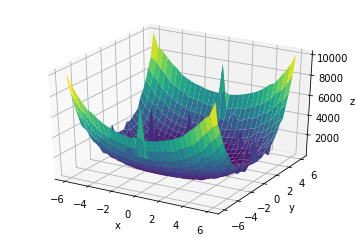

In [2]:
def z(x, y):
    return (np.tan(x*y+0.4) - x*x)**2 + (0.6*x*x+2*y*y-1)**2

x = np.linspace(-6, 6, 30)
y = np.linspace(-6, 6, 30)

X, Y = np.meshgrid(x, y)
Z = z(X, Y)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

Построим более наглядный график, интерактивный

In [3]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot

In [4]:
init_notebook_mode(connected=True)

x = np.linspace(-30, 30, 100)
y = np.linspace(-30, 30, 100)
Y, X = np.meshgrid(x, y)
Z = z(X, Y)

trace = go.Surface(z=Z, colorscale='Viridis')
iplot([trace])

Задача невыпукла, так что ограничимся пока предложенными итеративными методами.

### 1. Графический метод

Построим пересечение графиков и посмотрим, в каких точках происходит пересечение

x = -0.3798701, y = 0.6757256
x = 1.0483806, y = 0.4126123
x = -1.0484064, y = -0.4126255
x = 0.3798443, y = -0.6758221


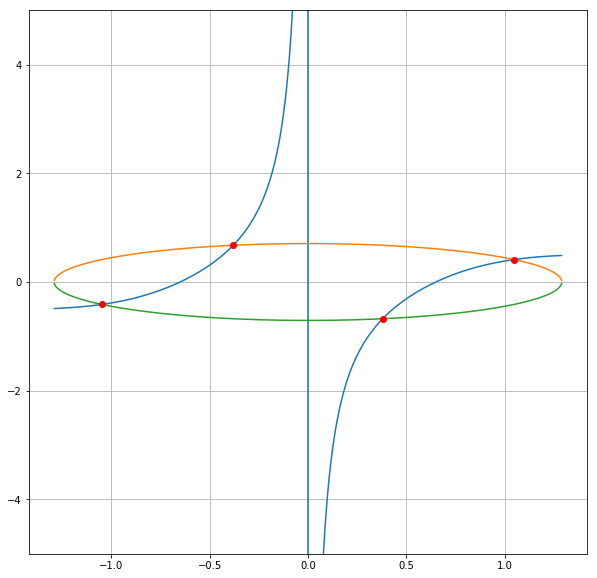

In [5]:
x = np.linspace(-1.29, 1.29, 100000)
# выразим y из уравнений и построим график
y1 = (np.arctan(x**2)-0.4)/x 
y2 = np.sqrt((1-0.6*x**2)/2) # верхняя часть эллипса
y3 = -np.sqrt((1-0.6*x**2)/2) # нижняя часть эллипса

idx1 = np.argwhere(np.diff(np.sign(y1 - y2)))
idx2 = np.argwhere(np.diff(np.sign(y1 - y3)))

plt.figure(figsize=(10,10))
plt.ylim(-5, 5)
plt.plot(x, y1, '-')
plt.plot(x, y2, '-')
plt.plot(x, y3, '-')
plt.plot(x[idx1], y1[idx1], 'ro')
plt.plot(x[idx2], y1[idx2], 'ro')
plt.grid()

for i in idx1:
    if abs(x[i])>1e-2: # почему-то считает еще в точке 0, убираем её
        print('x = %.7f, y = %.7f' %(x[i], y1[i]))
for j in idx2:
    if abs(x[j])>1e-2:
        print('x = %.7f, y = %.7f' %(x[j], y1[j]))

Данные точки — наше решение. Теперь получим их непосредственно через требуемые методы

### 2. Scipy, SymPy

Посчитаем сначала решение через готовые функции в библиотеках sympy и scipy

In [6]:
# через sympy
from sympy import nsolve, tan, Symbol
x = Symbol('x')
y = Symbol('y')
f1 = tan(x*y + 0.4) - x*x
f2 = 0.6*x**2 + 2*y**2 - 1
print(nsolve((f1, f2), (x, y), (1, 1)))

Matrix([[1.04840014110262], [0.412622276714188]])


In [7]:
# через scipy 
# работает по алгоритму http://www.math.utah.edu/software/minpack/minpack/hybrd.html
# является модификацией алгоритма https://en.wikipedia.org/wiki/Powell's_method
from scipy.optimize import fsolve

def sys_eq(p):
    x, y = p
    return (np.tan(x*y+0.4) - x*x, 0.6*x*x+2*y*y-1)

x, y =  fsolve(sys_eq, (1, 1))
print('x = %.7f, y = %.7f' % (x, y))
print(sys_eq((x, y))) # должно быть ~(0,0)

x = 1.0484001, y = 0.4126223
(1.2229328660851024e-11, 9.981127035985082e-12)


Как видим, методы дают одну точку. Но в зависимости от начального решения получаются разные ответы. Например, если стартовать не из (1,1), а из точки (49, 49), то получается иное решение, совпадающее с одним из полученных графически

In [8]:
x, y =  fsolve(sys_eq, (49, 49))
print('x = %.7f, y = %.7f' % (x, y))
print(sys_eq((x, y))) # должно быть ~(0,0)

x = -0.3798484, y = 0.6758066
(1.1013856493491403e-11, -8.757328195940772e-12)


Отсюда делаем вывод, что наши итерационные методы надо запускать из разных начальных точек и смотреть, к каким 4 точкам будут сходиться в основном

In [13]:
for i in range(1, 70, 10):
    x, y =  fsolve(sys_eq, (i, i))
    print('x = %.7f, y = %.7f' % (x, y))
    print(sys_eq((x, y))) # должно быть ~(0,0)

x = 1.0484001, y = 0.4126223
(1.2229328660851024e-11, 9.981127035985082e-12)
x = -2.0788650, y = 1.0498118
(0.3330048486864703, 3.797217426833857)
x = 1.0484001, y = 0.4126223
(-1.2239098623467726e-11, 6.091571691513309e-12)
x = -0.3798484, y = 0.6758066
(8.203410173379666e-12, -4.641509399050392e-12)
x = -0.3798484, y = 0.6758066
(-5.849876139052412e-12, 6.7268413062038235e-12)
x = -0.3798484, y = 0.6758066
(-7.396028234296637e-13, 1.91402449445377e-13)
x = -1.0484001, y = -0.4126223
(1.9206858326015208e-13, -1.3655743202889425e-13)


### 3. МПИ


\begin{cases}
        tg(xy + 0.4) - x^2 = 0,  \\
        0.6x^2 +2y^2 - 1 = 0;
\end{cases}

В связи со сложностью представления ситсемы в виде $u=f(u)$ таким, что f будет сжимающим, и фактом, что мы имеем 4 решения, МПИ в данном случае может не работать и вообще не сойтись. Проверим на таком итерационном процессе

\begin{cases}
        x = \cfrac{tg(xy + 0.4)}{x},  \\
        y = \cfrac{1 - 0.6x^2}{2y};
\end{cases}

In [14]:
def f(p):
    x, y = p
    return ((np.tan(x*y+0.4))/x, (1-0.6*x*x)/(2*y))

def mpi(begin, iter):
    x, y = begin
    step1 = norm(np.array(f([x,y])) - [x,y]) # евклидова норма
    n = 0
    xs, ys = [x], [y]
    for _ in range(iter):
        x, y = f([x, y])
        xs.append(x)
        ys.append(y)
        n += 1
    print('{} iterations'.format(n))
    return [x, y]

In [15]:
for i in range(1, 40):
    res = mpi((1, 1), i)
    print('Solution: ' + str(res))
    print('Невязка: ' + str(sys_eq(res)))

1 iterations
Solution: [5.797883715482887, 0.2]
Невязка: (55.510671277190056, 19.249273346956986)
2 iterations
Solution: [15.372182546097973, -47.92318336739247]
Невязка: (-238.5459570158588, 4734.045405867781)
3 iterations
Solution: [-0.14584531367465087, 1.4688339530687935]
Невязка: (0.1666737813547684, 3.327708876687912)
4 iterations
Solution: [-1.2886573599127722, 0.3360616374045814]
Невязка: (-1.693718152493119, 0.2222575230245103)
5 iterations
Solution: [0.025670408802850708, 0.005381937184980715]
Невязка: (0.42229711093839356, -0.9995466875714105)
6 iterations
Solution: [16.476406124842455, 92.86661881308437]
Невязка: (-270.8554020484295, 17410.30095482388)
7 iterations
Solution: [0.037420584176236026, -0.8715896914491689]
Невязка: (0.38345705398742785, 0.5201773605529694)
8 iterations
Solution: [10.284643133709352, -0.5731824445208096]
Невязка: (-104.76824803057976, 63.12140686206665)
9 iterations
Solution: [0.09778038421956083, 54.489047274358]
Невязка: (-0.62987890924868, 593

Как видим, на всех первых 40 итерациях, невязка шага нигде не меньше $10^{-1}$, а иногда и вообще подлетает до небес. В данном случае делаем вывод, что МПИ не сходится, поэтому попробуем метод Ньютона

### 3. Метод Ньютона

In [19]:
def invJ(u):
    x, y = u
    return np.dot([[4*y, -(x)/(np.cos(x*y+0.4))**2], [-1.2*x, y/(np.cos(x*y+0.4))**2-2*x]],
                  (np.cos(x*y+0.4))**2/(4*(y**2)-1.2*(x**2)-8*x*y*((np.cos(x*y+0.4))**2)))

#def sys_eq(p)
def newton(start0, iter):
    x, y = start0
    for _ in range(iter):
        x, y = x - np.dot(invJ([x,y]), sys_eq([x,y]))[0],\
               y - np.dot(invJ([x,y]), sys_eq([x,y]))[1]
    return [x, y]

Подобрали примерно такие начальные приближения, при которых будут искомые корни:

In [20]:
start = [-2, 1, 3, 4]
for i in start: # начальное приближение
    for j in range(1, 30): # итераций
        res = newton([i, i], j)
        if sys_eq(res)[0]<1e-5 and sys_eq(res)[1]<1e-5:
            print('\nНачальное значение: {}'.format([i,i]))
            print('Количество итераций: {}'.format(j))
            print('Результат: {}'.format((round(res[0], 5), round(res[1], 5)))) 
            print('Невязка: ' + str(sys_eq(res)))
            break


Начальное значение: [-2, -2]
Количество итераций: 7
Результат: (-1.0484, -0.41262)
Невязка: (-1.7838590604668525e-09, 8.649678751027068e-10)

Начальное значение: [1, 1]
Количество итераций: 5
Результат: (1.0484, 0.41262)
Невязка: (1.2125189741141185e-10, 8.167622134180874e-11)

Начальное значение: [3, 3]
Количество итераций: 6
Результат: (-0.37985, 0.67581)
Невязка: (-5.387321581173943e-06, 3.237919443899173e-06)

Начальное значение: [4, 4]
Количество итераций: 9
Результат: (0.37985, -0.67581)
Невязка: (1.0045372672573549e-07, 8.258058243892918e-07)


Как видим, получившиеся корни совпали с тем, что мы получили графически и из готовых функций. 

Область сходимости: $\Omega = {R}^2$